# My Diffusion Model - Model prototyping

## Setting up

### libs and imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow_addons as tfa
from matplotlib.colors import Normalize
import datetime
import keras_tuner as kt
import random
import os
import json
from PIL import Image
import imageio

print(tf.__version__)

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# for some fucking reason linspace dont work on GPU, who tf knows
def linspace(*args):
    with tf.device('/CPU:0'):
        return tf.linspace(*args)

c:\Users\brain\My Drive (brain@roforco.com)\CodeInDocs\MyDiffusionModel\.venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brain\My Drive (brain@roforco.com)\CodeInDocs\MyDiffusionModel\.venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work

2.10.0
Num GPUs Available:  1


### Data

(89400, 16, 16, 3)


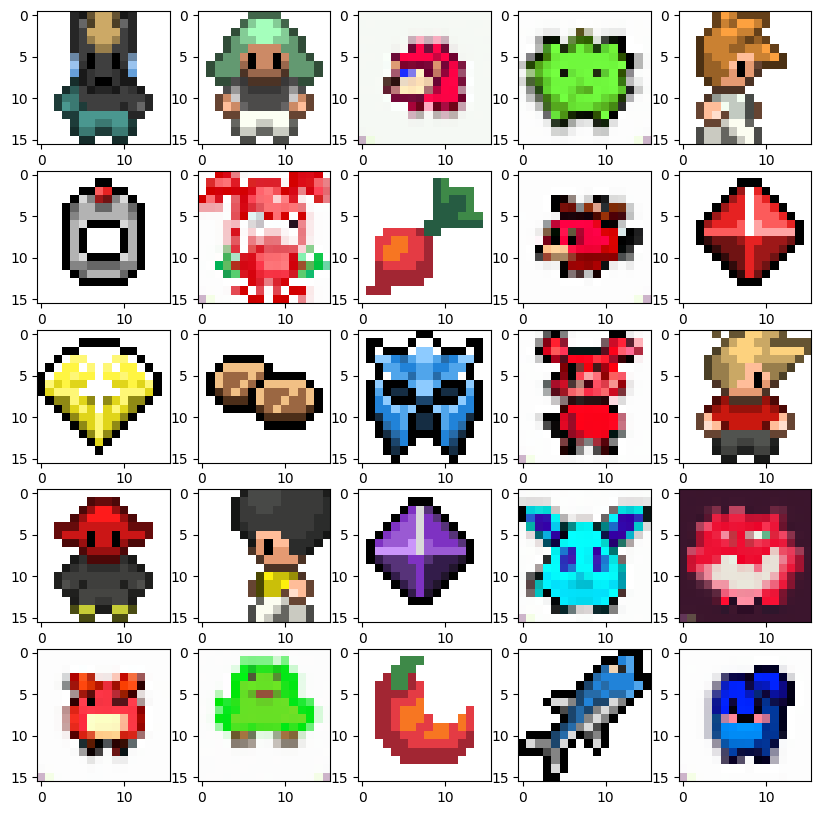

In [3]:
# Define the current path
current_path = Path("C:/Users/brain/My Drive (brain@roforco.com)/CodeInDocs/MyDiffusionModel/notebooks/model_prototyping.ipynb").resolve()

#Load the data
data = np.load(current_path.parent.parent / "data" / "sprites_1788_16x16.npy")
print(data.shape)

#Shuffle the data
np.random.shuffle(data)

#plot data
fig, axes = plt.subplots(5,5, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i])
plt.show()

### Variables

In [4]:
# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# construct DDPM noise schedule
b_t = (beta2 - beta1) * linspace(0, 1, timesteps + 1) + beta1
b_t = tf.cast(b_t, tf.float32)  # Ensure b_t is float32
a_t = 1 - b_t
a_t = tf.cast(a_t, tf.float32)  # Ensure a_t is float32
ab_t = tf.exp(tf.cumsum(tf.math.log(a_t), axis=0))
ab_t = tf.concat([[1.0], ab_t[1:]], axis=0)
ab_t = tf.cast(ab_t, tf.float32) # Ensure ab_t is float32

print(ab_t.shape)
print(ab_t[:10])
print(ab_t[1])

#Save directory for the weights
save_dir = current_path.parent.parent / "weights"

(501,)
tf.Tensor(
[1.         0.9997602  0.9995807  0.99936134 0.9991023  0.9988036
 0.9984652  0.99808717 0.9976696  0.99721247], shape=(10,), dtype=float32)
tf.Tensor(0.9997602, shape=(), dtype=float32)


### Set Seed

In [5]:
#Set seed for reproducibility
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # Ensures reproducibility for certain hash-based operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
set_seed(245987)

## Model Architecture

In [5]:
def ResidualConvBlock(in_channels, out_channels, is_res = False, kernel_size=3, stride=1, padding="same", name = "ResidualConvBlock"):
    """A Conv block with "possible" residual connection
    Args:
        shape (tuple): shape of the input tensor [ (height, width, channels) without including the batch size. ]
        out_channels (int): number of output channels
        is_res (bool, optional): whether to use residual connection or not
        kernel_size (int, optional): Defaults to 3.
        stride (int, optional): Defaults to 1.
        padding (str, optional): Defaults to "same".
    Returns:
        functional keras Model: ResidualConvBlock
    """
    inputs = keras.Input(shape=(None,None,in_channels), name = "ResidualConvBlock_input")
    
    # First Convolutional Layer
    x = layers.Conv2D(out_channels, kernel_size, stride, padding)(inputs) # channels last by default
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    
    # Second Convolutional Layer
    x = layers.Conv2D(out_channels, kernel_size, stride, padding)(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    
    # Add the residual connection specified
    if is_res:
        if in_channels == out_channels:
            # if the number of channels is the same, we can add the shortcut directly
            x = layers.Add()([x, inputs])
        else:
            # if the number of channels is different, translate the shortcut to the right number of channels through a 1x1 convolution
            translated_inputs = layers.Conv2D(out_channels, 1, 1, padding)(inputs)
            x = layers.Add()([x, translated_inputs])
            
        # Scale by sqrt(0.5) to normalize the variance
        x = layers.Lambda(lambda x: x / 1.414)(x)

    ResidualConvBlock = keras.Model(inputs=inputs, outputs=x, name=name)
    # ResidualConvBlock.summary()
    # keras.utils.plot_model(ResidualConvBlock, "ConvBlock.png", show_shapes=True)
    
    return ResidualConvBlock

# TEST CODE FOR ResidualConvBlock
# Res = ResidualConvBlock(3, 64, is_res=True)
# Res2 = ResidualConvBlock(3, 64, is_res=False)
# # Res2.set_weights(Res.get_weights())
# out = Res(tf.ones((1,16,16,3)))
# out2 = Res2(tf.ones((1,16,16,3)))
# print(out[0][0][0])
# print(out2[0][0][0])

def Encoder(in_channels, out_channels, name = "Encoder"):
    """Encoder block for Unet
    Args:
        out_channels (int): number of output channels
    Returns:
        keras functional Model: Encoder
    """
    inputs = keras.Input(shape=(None,None,in_channels), name = "Encoder_input")
    x = ResidualConvBlock(in_channels, out_channels, name="ResidualConvBlock1")(inputs)
    x = ResidualConvBlock(out_channels, out_channels, name="ResidualConvBlock2")(x)
    x = layers.MaxPooling2D(strides=2)(x)
    Encoder = keras.Model(inputs=inputs, outputs=x, name=name)
    # Encoder.summary()
    
    return Encoder

# TEST CODE FOR Encoder
# e = Encoder(3, 64)
# out = e(tf.ones((1,16,16,3)))
# print(out.shape)

def Decoder(in_channels, out_channels, name = "Decoder"):
    """Decoder block for Unet
    Args:
        in_channels (int): TOTAL: input_channels + skip_channels
        out_channels (int): number of output channels
    Returns:
        Keras Model: Decoder
    """
    inputs = keras.Input(shape=(None,None,int(in_channels/2)), name = "Decoder_input")
    skip_connection = keras.Input(shape=(None,None,int(in_channels/2)), name = "Decoder_skip_connection")
    
    x = layers.Concatenate()([inputs, skip_connection]) # axis = -1 default
    x = layers.Conv2DTranspose(out_channels, 2, 2)(x) # filters, kernel_size, strides
    x = ResidualConvBlock(out_channels, out_channels, name="ResidualConvBlock1")(x)
    x = ResidualConvBlock(out_channels, out_channels, name="ResidualConvBlock2")(x)
    
    Decoder = keras.Model(inputs=[inputs, skip_connection], outputs=x, name=name)
    # Decoder.summary()
    
    return Decoder

# TEST CODE FOR Decoder
# d = Decoder(256, 64)
# out = d([tf.ones((1,4,4,128)), tf.ones((1,4,4,128))])
# print(out.shape)

def TimeEmbeddingBlock(out_channels):
    """Time Embedding block for Unet
    Args:
        out_channels (int): number of output channels
    """
    inputs = keras.Input(shape=(1,), name = "TimeEmbedding_input")
    x = layers.Dense(out_channels)(inputs)
    x = layers.Activation(tf.nn.gelu)(x)
    x = layers.Dense(out_channels)(x)
    x = layers.Reshape((1,1,-1))(x)
    
    TimeEmbeddingBlock = keras.Model(inputs=inputs, outputs=x, name="TimeEmbeddingBlock")
    # TimeEmbeddingBlock.summary()
    
    return TimeEmbeddingBlock

# TEST CODE FOR TimeEmbeddingBlock
# print(TimeEmbeddingBlock(128)(tf.ones((1,1))).shape)

### Unet

Model: "unet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0 (unused)
                                                                 
 innitial_block (Functional)  (None, None, None, 64)   39488     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 Encoder1 (Functional)       (None, None, None, 64)    148736    
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 Encoder2 (Functional)       (None, None, None, 128)   518656    
                                                                 
 dropout_2 (Dropout)         multiple                  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0.002 0.004 0.    0.004 0.004 0.004 0.    0.    0.002 0.   ], shape=(10,), dtype=float32)
(10, 16, 16, 3)


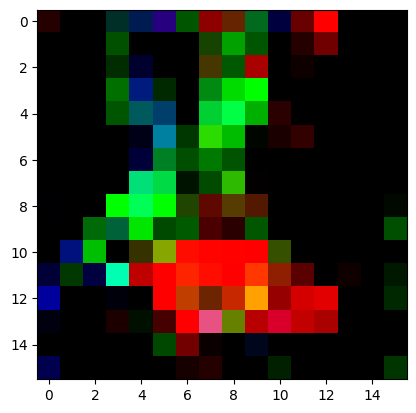

In [6]:
class Unet_model(keras.Model):

    def __init__(self, in_channels, nC = 64, height=16, skip = True, dropout_rate=[0.1,0.2,0.3,0.4]):  
        """innitializes Unet

        Args:
            in_channels (int): number of channels in input image, RGB = 3
            nC (int, optional): how many channels hidden channels in the first encoding step. Defaults to 64.
            height (int, optional): height of image. (must be factor of 4) Defaults to 16.
            dropout_rate (list, optional): dropout rate for each layer LEVEL, 4 total lvl1 = innitial, lvl4 = bottleneck. Defaults to [0.1,0.2,0.3,0.4].
        """

        super().__init__()
        self.in_channels = in_channels
        self.nC = nC
        self.h = height
        self.skip = skip
        self.dropout_rate = dropout_rate
        
        # Rescale the input image to [-1, 1]
        self.rescaling = layers.Rescaling(1./127.5, offset = -1, input_shape=(height, height, in_channels))
        
        # Initialize the Encoder
        self.innitial_block = ResidualConvBlock(in_channels, nC, name="innitial_block", is_res=True) # 16, 16, nC
        self.dropout0 = layers.Dropout(dropout_rate[0])
        
        #Encover 1 and 2
        self.e1 = Encoder(nC, nC, name = "Encoder1") # 8, 8, nC
        self.dropout1 = layers.Dropout(dropout_rate[1])
        self.e2 = Encoder(nC, 2*nC, name = "Encoder2") # 4, 4, 2nC
        self.dropout2 = layers.Dropout(dropout_rate[2])
        
        # Encoder output, reducing to 1x1 spatial resolution
        self.encoder_output = keras.Sequential([ # 1, 1, 2nC
            layers.AveragePooling2D(height//4), 
            layers.Activation(tf.nn.gelu),
            layers.Dropout(dropout_rate[3]),
        ], name = "Encoder_output") 
        
        #Bottleneck
        self.bottleneck = keras.Sequential([ # 4, 4, 2nC
            layers.Conv2DTranspose(2*nC, int(height/4), int(height/4)), # filters, kernel_size, strides
            tfa.layers.GroupNormalization(groups=8),
            layers.Activation(tf.nn.relu),
            layers.Dropout(dropout_rate[3]),
        ], name = "Bottleneck") 
        
        # Time embeddings
        self.time_embedding1 = TimeEmbeddingBlock(2*nC) # 1, 1, 2nC
        self.time_embedding2 = TimeEmbeddingBlock(nC) # 1, 1, nC
        
        # Decoder 1 and 2
        self.d1 = Decoder(4*nC, nC, name = "Decoder1") # 4, 4, 4nC -> 8, 8, nC
        self.d2 = Decoder(2*nC, nC, name = "Decoder2") # 8, 8, 2nC -> 16, 16, nC
        
        #Output Layer
        self.output_layer = keras.Sequential([ # 16, 16, 2nC -> 16, 16, nC ->16, 16, in_channels
            layers.Conv2D(nC, 3, 1, "same"),
            tfa.layers.GroupNormalization(groups=8),
            layers.Activation(tf.nn.relu),
            # layers.Dropout(dropout_rate[0]), #Might remove
            layers.Conv2D(in_channels, 3, 1, "same"),
        ], name = "OutputLayer") 
        
    @tf.function  
    def call(self, images, t=tf.constant([0.0]), training=False):
        """forward pass of Unet
        Args:
            images : (batch, h, w, channels) : input image
            t : tensor(batch, 1)      : fraction: current time step / total timesteps

        Returns:
            out: (batch, in_channels, h, w) : ouptut of Unet
        """
        
        # apply rescaling to [-1, 1] if image is currenctly in [0, 255]
        if images.dtype == tf.uint8:
            images = self.rescaling(images)
        # tf.print(f"max: {tf.reduce_max(images)}, min: {tf.reduce_min(images)}")
        
        # innilialize the encoder
        innitial = self.innitial_block(images, training=training) # 16, 16, nC
        dropped0 = self.dropout0(innitial, training=training)
        
        # Encoder 1 and 2
        e1 = self.e1(dropped0, training=training) # 8, 8, nC
        dropped1 = self.dropout1(e1, training=training)
        
        e2 = self.e2(dropped1, training=training) # 4, 4, 2nC
        dropped2 = self.dropout2(e2, training=training)
        
        # Encoder output
        encoder_output = self.encoder_output(dropped2, training=training) # 1, 1, 2nC
        
        # Bottleneck
        bottleneck = self.bottleneck(encoder_output, training=training) # 4, 4, 2nC
        
        # Time embeddings
        time_embedding1 = self.time_embedding1(t) # 1, 1, 2nC
        time_embedding2 = self.time_embedding2(t) # 1, 1, nC
        
        # Decoder 1 and 2
        d1 = self.d1([bottleneck + time_embedding1, e2], training=training) # 8, 8, nC
        dropped3 = self.dropout2(d1, training=training)
        
        d2 = self.d2([dropped3 + time_embedding2, e1], training=training) # 16, 16, nC
        dropped4 = self.dropout1(d2, training=training)
        
        # Output Layer
        if self.skip:
            concatenated = tf.concat([dropped4, innitial], axis=-1) # 16, 16, 2nC
            out = self.output_layer(concatenated, training=training) # 16, 16, in_channels
        else: 
            out = self.output_layer(dropped4, training=training) # 16, 16, in_channels
        
        return out
    
    @tf.function
    def train_step(self, data):
        """_summary_
        Args:
            data (tensor): images of shape (batch, h, w, channels)
                format: ( (all x passed in fit) , (all y passed in fit) ) 
                multiple data points passed in fit as tuples or array: .fit( (x1,x2), y, batch_size=1, epochs=1)
        Returns:
            _type_: _description_
        """

        x = data

        # rescalse the input to [-1, 1] if it is in [0, 255]
        if x.dtype == tf.uint8:
            x = self.rescaling(x)

        # add random noise at random t to the current batch of images
        noise = tf.random.normal(tf.shape(x)) # random noise for each image in the batch
        t = tf.random.uniform((tf.shape(x)[0],), minval=0, maxval=timesteps+1, dtype=tf.int32) # random t for each image in the batch
        x_pert = perturb_input(x, t, noise)
        
        t_fraction = tf.cast(t / timesteps, dtype=tf.float32)
        t_fraction = tf.reshape(t_fraction, (-1,1))

        # calculate loss
        with tf.GradientTape() as tape:
            pred_noise = self(x_pert, t_fraction, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y=noise, y_pred=pred_noise)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(noise, pred_noise)
                
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x = data

        # rescalse the input to [-1, 1] if it is in [0, 255]
        if x.dtype == tf.uint8:
            x = self.rescaling(x)
        
        # add random noise at random t to the current batch of images
        noise = tf.random.normal(tf.shape(x))
        t = tf.random.uniform((tf.shape(x)[0],), minval=0, maxval=timesteps+1, dtype=tf.int32) # random t for each image in the batch
        x_pert = perturb_input(x, t, noise)

        t_fraction = tf.cast(t / timesteps, dtype=tf.float32)
        t_fraction = tf.reshape(t_fraction, (-1,1))

        # get prediction
        pred_noise = self(x_pert, t_fraction, training=False)
        
        loss = self.compiled_loss(noise, pred_noise)
        self.compiled_metrics.update_state(noise, pred_noise)
        
        # tf.print(f"Batch Loss: {loss}")
        return {m.name: m.result() for m in self.metrics}

# TEST CODE FOR Unet_model

tf.config.run_functions_eagerly(True)

dummy_data = data[:10]

test_Unet = Unet_model(3)
_ = test_Unet(keras.Input(shape=(16,16,3)), keras.Input(shape=(1,)))
test_Unet.summary()

t = tf.random.uniform((tf.shape(dummy_data)[0],), minval=0, maxval=3, dtype=tf.int32) # random t for each image in the batch
t = tf.cast(t / timesteps, dtype=tf.float32)
print(t)
t = tf.reshape(t, (-1,1))  

out = test_Unet(dummy_data, t)

print(out.shape)
plt.imshow(out[0])
plt.show()

## Training

In [8]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    """

    Args:
        x (_type_): _description_
        t (_type_): _description_
        noise (_type_): _description_

    Returns:
        perturbed image: (batch, h, w, channels) computed with (#t, 1, 1, 1)
            ex. t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    """
    
    gathered = tf.gather(ab_t, t)
    
    a = tf.sqrt(gathered)
    a = tf.reshape(a, (-1, 1, 1, 1))
    # print(f"a: {a[:2]}")
    
    b = 1.0 - gathered
    b = tf.reshape(b, (-1, 1, 1, 1))
    # print(f"b: {b[:2]}")

    return a * x + b * noise


# x = data[:10]
# t = tf.random.uniform((tf.shape(x)[0],), minval=0, maxval=2, dtype=tf.int32)
# noise = tf.random.normal(tf.shape(x))

# print(t)
# print(tf.gather(ab_t, t))

# perturb_test = perturb_input(x, t, noise)

# print(x[0][0][0])
# print(x[1][0][0])
# print(noise[0][0][0])
# print(noise[1][0][0])
# print(perturb_test[0][0][0])
# print(perturb_test[1][0][0])

# @tf.function
# def test_func():
#     t = tf.random.uniform((), 0, timesteps+1, dtype=tf.int32)
#     print(f"tracing {t}")
#     ab = ab_t[t]
#     x = tf.constant(1, dtype=tf.float32)
#     noise = tf.constant(1, dtype=tf.float32)
#     p = perturb_input(x, t, noise)
#     return ab, p, t
    
# ab1, p1, t1 = test_func()
# ab2, p2, t2 = test_func()

# real_ab1 = ab_t[t1]
# real_ab2 = ab_t[t2]
# real_p1 = perturb_input(tf.constant(1, dtype=tf.float32), t1, tf.constant(1, dtype=tf.float32))
# real_p2 = perturb_input(tf.constant(1, dtype=tf.float32), t2, tf.constant(1, dtype=tf.float32))

# print(t1, ab1, p1)
# print(t2, ab2, p2)
# print(t1, real_ab1, real_p1)
# print(t2, real_ab2, real_p2)

# concrete_function = test_func.get_concrete_function()

# logdir = "logs/fit/"
# writer = tf.summary.create_file_writer(logdir)

# # Log the graph to TensorBoard
# with writer.as_default():
#     tf.summary.graph(concrete_function.graph)
#     writer.flush()


### Hyperparameter Tuning

In [17]:
set_seed(98234567)
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
hp = kt.HyperParameters()

def build_hypermodel(hp, total_samples=data_subset.shape[0]*0.8):
    nC = hp.Int('nC', min_value=40, max_value=112, step=24) # 40, 64, 88, 112
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log') # 0.0001, 0.01
    # end_lr = hp.Float('end_learning_rate', min_value=1e-12, max_value=1e-8, sampling='log')
    batch_size = hp.Int('batch_size', min_value=50, max_value=150, step=50)
    # skip = hp.Boolean("skip connection")
    dropout_rates = [
        hp.Float('dropout_rate_0', min_value=0.0, max_value=0.3, step=0.05),
        hp.Float('dropout_rate_1', min_value=0.0, max_value=0.4, step=0.05),
        hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.05),
        hp.Float('dropout_rate_3', min_value=0.0, max_value=0.6, step=0.05)
    ]
    
    steps_per_epoch = total_samples // batch_size # Calculate the number of steps / batches per epoch
    decay_steps = steps_per_epoch * n_epoch # Number of steps to decay over
    
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=decay_steps,
        end_learning_rate=0,
        power=1.0)
    
    model = Unet_model(3, nC=nC, dropout_rate=dropout_rates)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()],
    )
    model.batch_size = batch_size
    return model

class MyBayesianOptimization(kt.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = self.hypermodel.build(hp)

        checkpoint_filepath = f'tuning_results/{project_name}/trial_{trial.trial_id}/cp-{{epoch:04d}}.ckpt'
        log_dir = "logs/fit/" + f"{project_name}-trial-{trial.trial_id}"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=1e-4,
                patience=4,
                verbose=1,
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=1
            ),
            tensorboard_callback
        ]

        # Fit with the provided arguments
        with tf.device('/GPU:0'):
            history = model.fit(*args, batch_size=model.batch_size, callbacks=callbacks, **kwargs)

        val_loss = history.history['val_loss'][-1] # Retrieve the validation loss
        return val_loss

#Create new tuner directory
project_name=current_time + "-v3_Bayesian"

#Get old tuner states / directories 
# project_name="20240621-202942"

tuner = MyBayesianOptimization(
    hypermodel=build_hypermodel,
    max_trials=50,
    overwrite=False,
    directory="tuning_results",
    project_name=project_name,
)

# tuner.reload()

# tuner.search_space_summary()

tuner.search(data_subset, epochs=10, validation_split=0.2)


Trial 50 Complete [00h 00m 56s]
default_objective: 0.35746797919273376

Best default_objective So Far: 0.2899591624736786
Total elapsed time: 01h 14m 04s


In [25]:
# Retrieve the best models
# best_models = tuner.get_best_models(num_models=1)

best_hps = tuner.get_best_hyperparameters(6)
# best_model = build_hypermodel(best_hps[0])

tuner.results_summary()

Results summary
Results in tuning_results\20240627-230412-v3_Bayesian
Showing 10 best trials
Objective(name="default_objective", direction="min")

Trial 16 summary
Hyperparameters:
nC: 112
learning_rate: 0.0010319507191395016
batch_size: 100
dropout_rate_0: 0.0
dropout_rate_1: 0.1
dropout_rate_2: 0.05
dropout_rate_3: 0.35000000000000003
Score: 0.2899591624736786

Trial 32 summary
Hyperparameters:
nC: 40
learning_rate: 0.0004210330570756084
batch_size: 100
dropout_rate_0: 0.1
dropout_rate_1: 0.0
dropout_rate_2: 0.05
dropout_rate_3: 0.4
Score: 0.2960263788700104

Trial 15 summary
Hyperparameters:
nC: 40
learning_rate: 0.00038305416753732047
batch_size: 100
dropout_rate_0: 0.15000000000000002
dropout_rate_1: 0.0
dropout_rate_2: 0.0
dropout_rate_3: 0.4
Score: 0.29791638255119324

Trial 27 summary
Hyperparameters:
nC: 40
learning_rate: 0.0006444266823116785
batch_size: 100
dropout_rate_0: 0.05
dropout_rate_1: 0.0
dropout_rate_2: 0.0
dropout_rate_3: 0.45
Score: 0.30162009596824646

Trial 31 

### Training Parameters

In [8]:
# training hyperparameters
batch_size = 100
n_epoch = 32

n_feat = 64 # 64 hidden dimension feature
height = 16 # 16x16 image

np.random.shuffle(data)
data_subset = data[:20000]

validation_split = 0.2
total_samples = data.shape[0] * (1-validation_split) # Total number of samples in the dataset that will be trained on (exclude val set)
steps_per_epoch = total_samples // batch_size # Calculate the number of steps / batches per epoch
decay_steps = steps_per_epoch * n_epoch # Number of steps to decay over

lrate=1e-3  # Start learning rate
end_lrate = 0     # End learning rate
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=lrate,
    decay_steps=decay_steps,
    end_learning_rate=end_lrate,
    power=1.0)

### Single Full Training Run

Single full training run using predefined hyperparameters

In [131]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"iterations: {self.model.optimizer.iterations}")
        print(f"mylearning rate: {self.model.optimizer.lr(self.model.optimizer.iterations)}")
        print(f"Epoch {epoch+1}: Learning rate is {lr.numpy()}")
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"iterations: {self.model.optimizer.iterations}")
        print(f"Epoch {epoch+1} end: Learning rate is {lr.numpy()}")

# Training run variables/settings
batch_name = "custom_model3"
tf.config.run_functions_eagerly(False)    
# set_seed(98234567)
    
#Pre-run setups
np.random.shuffle(data)
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# logging
log_dir = "logs/fit/" + current_time + f"-{batch_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_filepath = f'checkpoints/{batch_name}/cp-{{epoch:04d}}.ckpt'

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=4,
        verbose=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    tensorboard_callback,
    # LearningRateLogger()
]

#Create model
custom_model = Unet_model(3, nC=n_feat, dropout_rate=[0.0, 0.0, 0.0, 0.0])
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()],
)

with tf.device('/GPU:0'):
    history = custom_model.fit(data, 
            batch_size=batch_size,
            epochs=n_epoch, 
            verbose=1, 
            validation_split=validation_split, 
            callbacks=callbacks
            )

Epoch 1/32
716/716 [==============================] - ETA: 0s - loss: 0.2665
Epoch 1: val_loss improved from inf to 0.21151, saving model to checkpoints/custom_model3\cp-0001.ckpt
716/716 [==============================] - 39s 48ms/step - loss: 0.2665 - val_loss: 0.2115 - val_mean_squared_error: 0.2115
Epoch 2/32
716/716 [==============================] - ETA: 0s - loss: 0.1950
Epoch 2: val_loss improved from 0.21151 to 0.19271, saving model to checkpoints/custom_model3\cp-0002.ckpt
716/716 [==============================] - 33s 46ms/step - loss: 0.1950 - val_loss: 0.1927 - val_mean_squared_error: 0.1927
Epoch 3/32
716/716 [==============================] - ETA: 0s - loss: 0.1736
Epoch 3: val_loss improved from 0.19271 to 0.16421, saving model to checkpoints/custom_model3\cp-0003.ckpt
716/716 [==============================] - 33s 46ms/step - loss: 0.1736 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 4/32
716/716 [==============================] - ETA: 0s - loss: 0.1579
Epo

### Multiple Full training runs

Based on the hyperparameters found during tuning, runs through all parameters in "best_hps" and does a full run for each

In [8]:
# training run variables
v3_fixedgraph = [] # the variable the models will be stored in
batch_name = "v3" # the name used to save the model checkpoints in files

set_seed(98234567)
tf.config.run_functions_eagerly(False)
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

for i,hp in enumerate(best_hps):
    print(f"Training model {i}")

    log_dir = "logs/fit/" + current_time + f"-{batch_name}-model-{i}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_filepath = f'checkpoints/{batch_name}/model-{i}/cp-{{epoch:04d}}.ckpt'

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=4,
            verbose=1,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        tensorboard_callback
    ]
    
    validation_split = 0.2
    total_samples = data.shape[0] * (1-validation_split) # Total number of samples in the dataset that will be trained on (exclude val set)
    model = build_hypermodel(hp, total_samples=total_samples)

    with tf.device('/GPU:0'):
        history = model.fit(data, 
                batch_size=model.batch_size,
                epochs=32, 
                verbose=1, 
                validation_split=validation_split, 
                callbacks=callbacks
                )
    
    v3_fixedgraph.append(model)

NameError: name 'best_hps' is not defined

In [16]:
### How to use tensorboard

# Dont use notebook commands, they suck, use cmd

# Start command:
#   tensorboard --logdir "C:/Users/brain/My Drive (brain@roforco.com)/CodeInDocs/MyDiffusionModel/notebooks/logs/fit"

# Deleting lingering programs if not closed properly
#   tasklist | findstr tensorboard
#   taskkill /IM tensorboard.exe /F

# If says "Duplicate plugins for name projector"
#   Go in file explorer and delete the -ensorboard folders

### Test

In [90]:
custom_test_models = v2_proper_lr # array of models, the models to be tested, 

test_dataset = data[:500]
debug_renders = [] # [x, x_scaled, noise, x_pert, pred_noise]
test_timesteps = []
test_losses = []

def custom_evaluate(model, loss_function, test_dataset, name=""):
    total_loss = 0
    model.training = False
    print(test_dataset.shape)
    
    with tf.device('/GPU:0'):
        for i,x in enumerate(test_dataset):   # x: images 

            x = x.reshape(1, 16, 16, 3)
            debug_renders.append(x[0])
            
            # rescalse the input to [-1, 1] if it is in [0, 255]
            if x.dtype == tf.uint8:
                x = model.rescaling(x)
            debug_renders.append(x[0])

            # add random noise at random t to the current batch of images
            noise = tf.random.normal(tf.shape(x))
            debug_renders.append(noise[0])
            t = np.random.randint(0, timesteps+1)
            test_timesteps.append(t)
            x_pert = perturb_input(x, t, noise)
            debug_renders.append(x_pert[0])
            
            # use network to recover noise
            pred_noise = model(x_pert, tf.constant([t/timesteps], dtype=tf.float32), training=False)  # Forward pass
            debug_renders.append(pred_noise[0])

            # Define the Loss Function
            loss = loss_function(noise, pred_noise)
            test_losses.append(loss)
            print(loss)
            total_loss += loss
            
            print(f"Model: {name}, Step: {i} compiled_loss: {total_loss/test_dataset.shape[0]}", end='\r')
            # break
    total_loss /= test_dataset.shape[0]
    
    print(f"Model: {name}, final total_loss: {total_loss}")
    return total_loss

for i,m in enumerate(custom_test_models):
    custom_evaluate(m, keras.losses.MeanSquaredError(), test_dataset, name=f"{i+1}")

(500, 16, 16, 3)
tf.Tensor(0.09956564, shape=(), dtype=float32)
tf.Tensor(0.07200483, shape=(), dtype=float32)926418722
tf.Tensor(1.0485084, shape=(), dtype=float32)7138121724
tf.Tensor(1.0435879, shape=(), dtype=float32)449193716
tf.Tensor(0.021103596, shape=(), dtype=float32)849869
tf.Tensor(0.07915495, shape=(), dtype=float32)7270155
tf.Tensor(1.1079144, shape=(), dtype=float32)337935925
tf.Tensor(0.058076873, shape=(), dtype=float32)0121155
tf.Tensor(0.0065770936, shape=(), dtype=float32)95583
tf.Tensor(0.081465326, shape=(), dtype=float32)239452
tf.Tensor(0.81688344, shape=(), dtype=float32)4055557
tf.Tensor(0.10490304, shape=(), dtype=float32)32639313
tf.Tensor(0.1215593, shape=(), dtype=float32)719603539
tf.Tensor(1.3083605, shape=(), dtype=float32)683739185
tf.Tensor(0.06532392, shape=(), dtype=float32)89152527
tf.Tensor(0.22825167, shape=(), dtype=float32)82564735
tf.Tensor(0.20222689, shape=(), dtype=float32)43673706
tf.Tensor(1.3030627, shape=(), dtype=float32)180055141
tf.T

In [136]:

# set_seed(245987)

tf.config.run_functions_eagerly(False)

custom_model.evaluate(data, batch_size=100)

894/894 [==============================] - 11s 12ms/step - loss: 0.0870 - mean_squared_error: 0.0870


[0.08699921518564224, 0.08699921518564224]

## Saving Models

In [12]:
def save_model(model, save_dir, name):
    """Saving the weights and config of a model

    Args:
        model (model): model to be saved
        save_dir (dir): main directory to save the model
        name (str): name of the model
    """
    
    models_dir = save_dir / name
    model.save_weights(f"{models_dir}/model_0")
    model_config = {
        "nC": model.nC,
        "dropout_rate": model.dropout_rate,
        "skip": model.skip,
    }
    with open(os.path.join(models_dir, f'model_0_config.json'), 'w') as f:
        json.dump(model_config, f)
        
def save_multiple_models(models, save_dir, group_name):
    """Saving the weights and config of multiple models

    Args:
        models (array): array of models to be saved
        save_dir (dir): main directory to save the models
        group_name (str): name of the group of models
    """
    
    
    models_dir = save_dir / group_name
    for i,m in enumerate(models):
        m.save_weights(f"{models_dir}/model_{i}")
        model_config = {
            "nC": m.nC,
            "dropout_rate": m.dropout_rate,
            "skip": m.skip,
        }
        with open(os.path.join(models_dir, f'model_{i}_config.json'), 'w') as f:
            json.dump(model_config, f)

save_dir = current_path.parent.parent / "weights"


## Loading Models

In [9]:
def load_models(model_dir, num, hp = None, epoch=None):
    """Loading the weights and config of multiple models

    Args:
        model_dir (dir): folder containing the models
        num (int): number of models to be loaded from that folder
        hp (hp, optional): if model should be loaded based on specific hyper parameter then specify here. Defaults to None.
        epoch (int, optional): which epoch of checkpoints to pick from. Defaults to None.

    Returns:
        array(models): array of loaded models
    """
    
    loaded_models = []
    
    for i in range(num):        
        
        if hp:
            loaded_model = build_hypermodel(hp)
        else:
            # Load model configuration
            with open(os.path.join(model_dir, f'model_{i}_config.json')) as f:
                model_config = json.load(f)

            # Recreate the model
            loaded_model = Unet_model(3, **model_config)
            
            loaded_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanSquaredError()],
            )

        # Load the weights
        if hp:
            loaded_model.load_weights(os.path.join(model_dir, f'cp-{epoch:04d}.ckpt'))
        else:
            loaded_model.load_weights(os.path.join(model_dir, f'model_{i}'))
        
        loaded_models.append(loaded_model)
        
        # loaded_model(keras.Input(shape=(16,16,3)), keras.Input(shape=(1,)))
        # loaded_model.summary()
    
    return loaded_models

save_dir = current_path.parent.parent / "weights"

# final_models = load_models(final_models_dir, 5)
# final_models2 = load_models(final_models2_dir, 5)
# final_models3 = load_models(final_models3_dir, 4)
# pre_dropout_models = load_models(pre_dropout_models_dir, 3)
# v2_proper_lr = load_models(v2_proper_lr_dir, 5)
# trial16 = load_models("tuning_results/20240627-230412-v3_Bayesian/trial_16", 1, hp = best_hps[0], epoch=10)


working_model = load_models(save_dir / "final_model", 1)[0]

## Sampling

In [11]:
def denoise_ddpm(x, t, pred_noise, z):
    noise = tf.sqrt(b_t[t]) * z
    mean = (x - pred_noise * ((1 - a_t[t]) / tf.sqrt(1 - ab_t[t]))) / tf.sqrt(a_t[t])
    return mean + noise

In [12]:
def sampling_ddpm(model, n_samples, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = tf.random.normal((n_samples, height, height, 3))

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        t = tf.constant([i / timesteps], dtype=tf.float32)
        z = tf.random.normal(samples.shape) if i > 1 else 0

        pred_noise = model(samples, t, training=False)

        samples = denoise_ddpm(samples, i, pred_noise, z)
        
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.numpy())

    intermediate = np.stack(intermediate)
    return samples.numpy(), intermediate

In [13]:
def denoise_ddim(x, t, t_prev, pred_noise):
    """define sampling function for DDIM, removes the noise using ddim
    removes predicted noise using noise schedule then adds some noise back

    Args:
        x (tensor: (batch, h, w, 3)): images to denoise
        t (int): current time step
        t_prev (int): previous time step
        pred_noise (tensor: (batch, h, w, 3)): predicted noise

    Returns:
        tensor: (batch, h, w, 3): denoised image
    """
    
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]

    x0_pred = tf.sqrt(ab_prev) / tf.sqrt(ab) * (x - tf.sqrt(1 - ab) * pred_noise) # Remove noise from image based on noise schedule DDIM
    dir_xt = tf.sqrt(1 - ab_prev) * pred_noise # Add some noise back
    
    return x0_pred + dir_xt


# x = [[[[0.5, 0.6, 0.7], [0.5, 0.6, 0.7]], [[0.5, 0.6, 0.7], [0.5, 0.6, 0.7]]]]
# t = 2
# t_prev = 1
# pred_noise = [[[[0.1, 0.1, 0.1], [0.1, 0.1, 0.1]], [[0.1, 0.1, 0.1], [0.1, 0.1, 0.1]]]]
# print(denoise_ddim(x, t, t_prev, pred_noise))
# expected_output ISH = [[[[0.45, 0.55, 0.65], [0.45, 0.55, 0.65]], [[0.45, 0.55, 0.65], [0.45, 0.55, 0.65]]]]

In [14]:
# MBY gotta change t input structure
def sampling_DDIM(model, n_samples, n=20):
    """sampling n images based on diffusion model

    Args:
        model (tf model): model used to predict noise
        n_samples (int): number of images to sample
        n (int, optional): total sampling steps to take (DDIM skips steps). Defaults to 20.
    """
    
    samples = tf.random.normal((n_samples, height, height, 3))
    
    intermediate = []
    stepsize = timesteps // n
    for i in range(timesteps, 0, -stepsize):
        print(f'sampling timestep {i:3d}', end='\r')
        
        t = tf.constant([i / timesteps], dtype=tf.float32)

        pred_noise = model(samples, t, training=False)
        # print(f"min: {tf.reduce_min(pred_noise)}, max: {tf.reduce_max(pred_noise)}")
        samples = denoise_ddim(samples, i, i-stepsize, pred_noise)
        intermediate.append(samples.numpy())
    
    intermediate = np.array(intermediate)
    return samples.numpy(), intermediate

samples, intermediate = sampling_DDIM(working_model, 250)
print(samples.shape)
print(intermediate.shape)


(250, 16, 16, 3)p  25
(20, 250, 16, 16, 3)


## Visualization

(56, 16, 16, 3)ep   1


C:\Users\brain\AppData\Local\Temp\ipykernel_10708\3374620019.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


i = 55, min: -1.0519156455993652 max: 1.0863070487976074


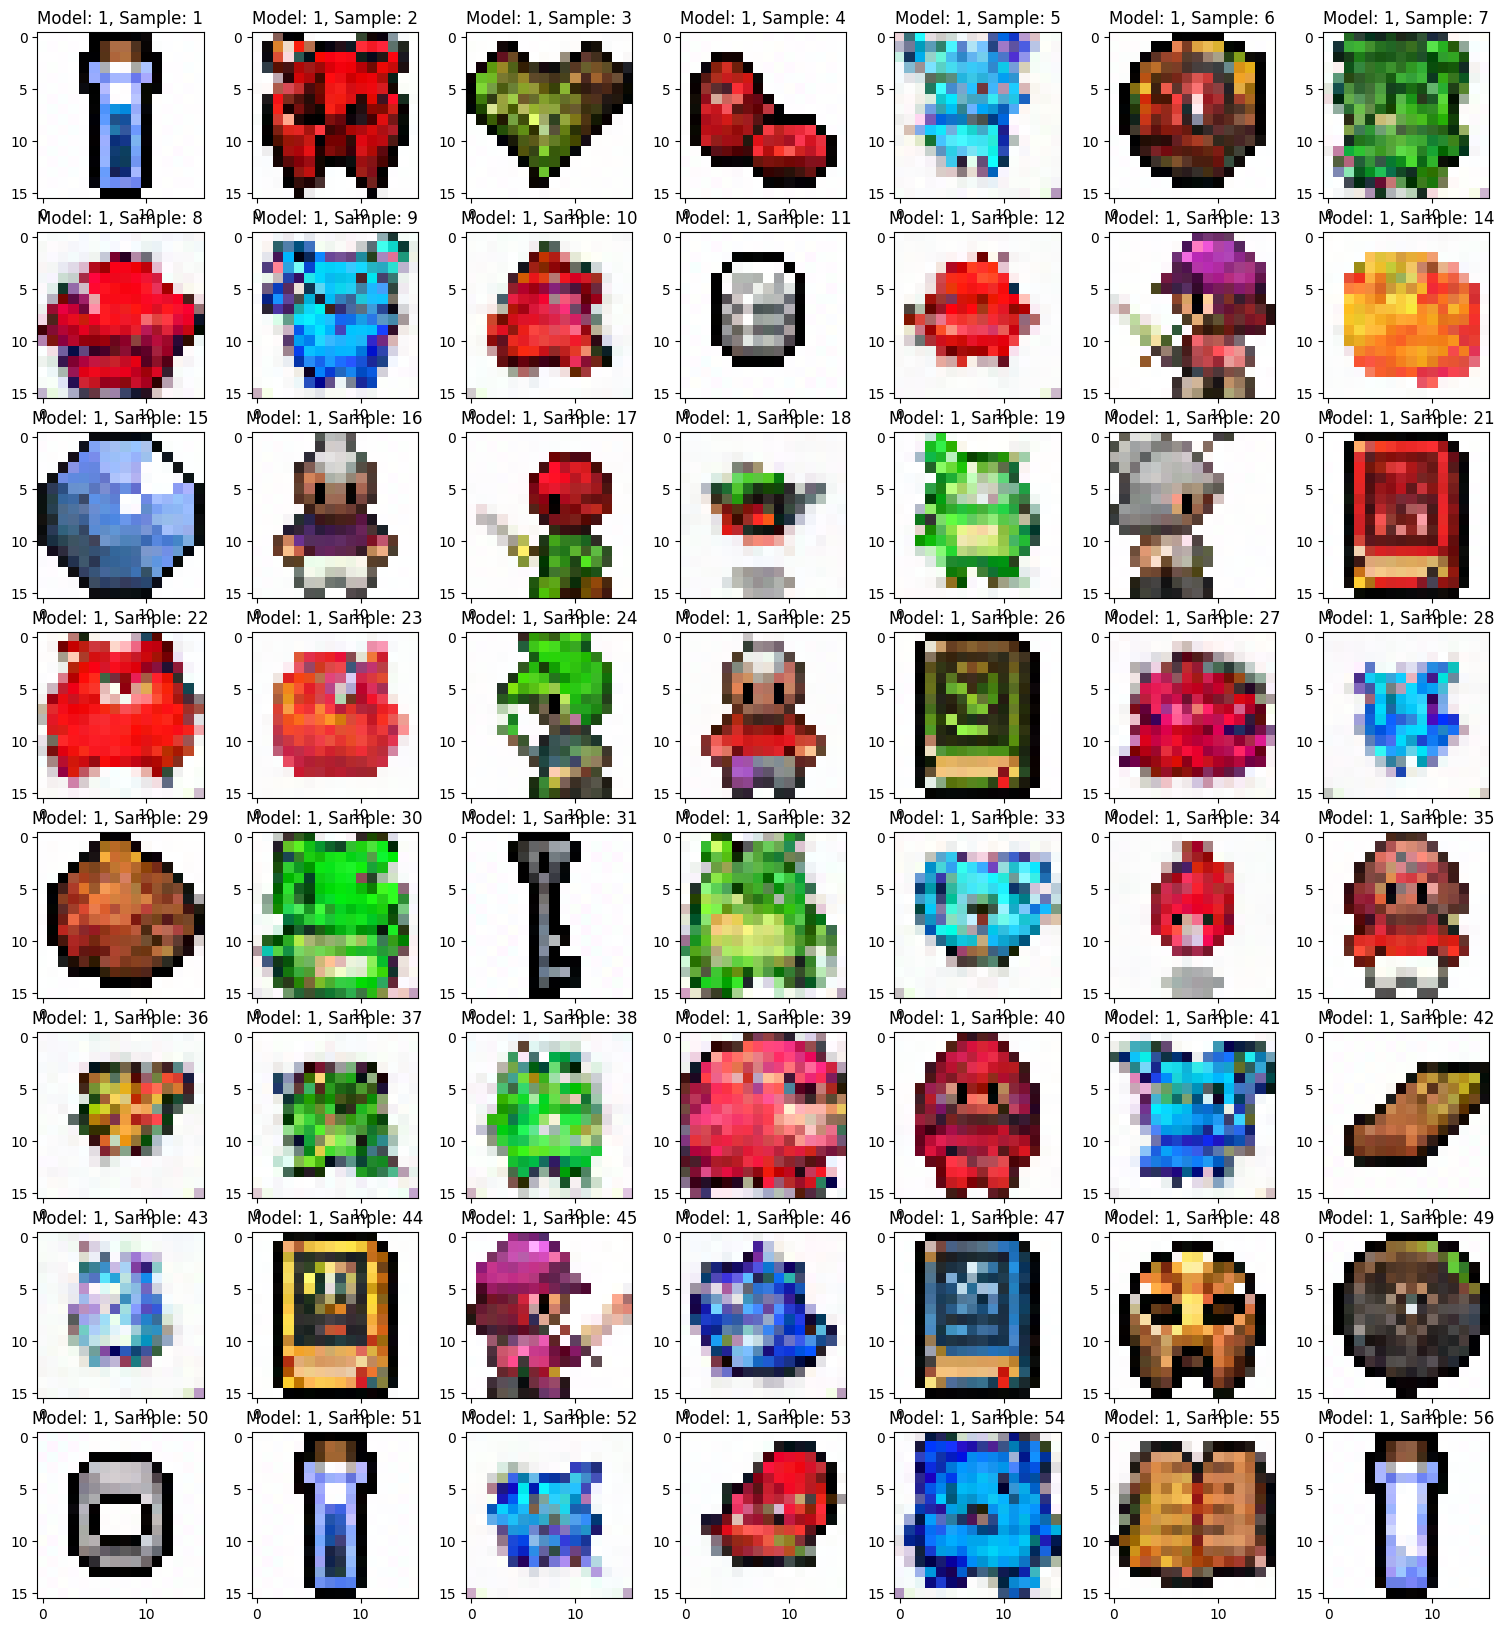

In [44]:
#Display variables
lines_per_model = 8 # how many lines samples to show per model (7 samples per line)

show_models = [working_model]

samples = []
intermediates = []
for m in show_models:
    # s, i = sampling_DDIM(m, 7*lines_per_model, n = 20)
    # samples.append(s)
    # intermediates = i
    s, i = sampling_ddpm(m, 7*lines_per_model)
    samples.append(s)
    intermediates = i
samples = np.concatenate(samples, axis=0)
print(samples.shape)



fig, axes = plt.subplots(lines_per_model*len(show_models),7, figsize=(15,2*lines_per_model*len(show_models)))

flattened_axes = axes.flatten()
for i, sample in enumerate(samples):
    ax = flattened_axes[i]
    ax.set_title(f'Model: {(i// (lines_per_model*7) )+1}, Sample: {i+1}')
    sample = (sample.clip(-1,1) + 1) / 2 # h,w,3
    ax.imshow(sample)

fig.subplots_adjust(hspace=0)
fig.show()
fig.tight_layout(pad=0)

sample = samples[i] # + 1) / 2
print(f"i = {i}, min: {tf.reduce_min(sample)} max: {tf.reduce_max(sample)}")

### Save images

In [160]:
samples, intermediate = sampling_ddpm(working_model, 1000)
samples = (samples.clip(-1,1) + 1) / 2

print(samples.shape)

savepath = current_path.parent.parent / "generations" / "custom_modelV4.npy"
np.save(savepath, samples)

(1000, 16, 16, 3)   1


### Create Gif

In [42]:
print(samples.shape)
print(intermediates.shape)

def normalize_image_data(images):
    # Normalize images from [-1, 1] to [0, 255]
    images = ((images.clip(-1,1) + 1) / 2.0) * 255
    return images.astype(np.uint8)

def resize_image(image, h, w, original = 16):
    
    tiles_per_row = w // original
    tiles_per_col = h // original

    # Tiling the image
    upscaled_image = np.repeat(np.repeat(image, tiles_per_col, axis=0), tiles_per_row, axis=1)
    return upscaled_image

def stitch_images(images, grid_shape, image_size, padding, outer_padding):
    num_images, _, _, channels = images.shape
    rows, cols = grid_shape
    
    # Calculate the size of the final stitched image including outer padding
    stitched_image_size = (
        rows * image_size + (rows - 1) * padding + 2 * outer_padding,  # Height with outer padding
        cols * image_size + (cols - 1) * padding + 2 * outer_padding,  # Width with outer padding
        channels  # Channels (e.g., 3 for RGB)
    )
    
    # Create an empty array for the stitched image with outer padding
    stitched_image = np.zeros(stitched_image_size, dtype=np.uint8)
    stitched_image.fill(255)  # Fill with white

    # Fill the stitched image with the individual images
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < num_images:
                # Calculate the position in the final image including outer padding
                top = i * (image_size + padding) + outer_padding
                left = j * (image_size + padding) + outer_padding
                
                # Place the image in the stitched image
                stitched_image[top:top + image_size, left:left + image_size, :] = images[index]
    
    return stitched_image

# Define grid shape (e.g., 7x5 grid) and other parameters
grid_shape = (7, 8)
image_size = 64 #target image size per image in the grid
padding = 16  # Padding between images
outer_padding = 16 # Outer padding around the grid

gif_filename = "generation_process2.gif"
save_path = current_path.parent.parent / "images" / gif_filename

stitched_images = []
for i,images in enumerate(intermediates):
    
    # Normalize image data
    normalized_images = normalize_image_data(images)

    # Resize images
    resized_images = np.array([resize_image(image, image_size, image_size) for image in normalized_images])

    # Stitch images
    stitched_image_array = stitch_images(resized_images, grid_shape, image_size, padding, outer_padding)

    # Convert the numpy array to an image using PIL
    stitched_image = Image.fromarray(stitched_image_array)
    stitched_images.append(stitched_image)

imageio.mimsave(save_path, stitched_images, format='GIF', duration=0.3)


(35, 16, 16, 3)
(32, 35, 16, 16, 3)


C:\Users\brain\AppData\Local\Temp\ipykernel_988\446406686.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


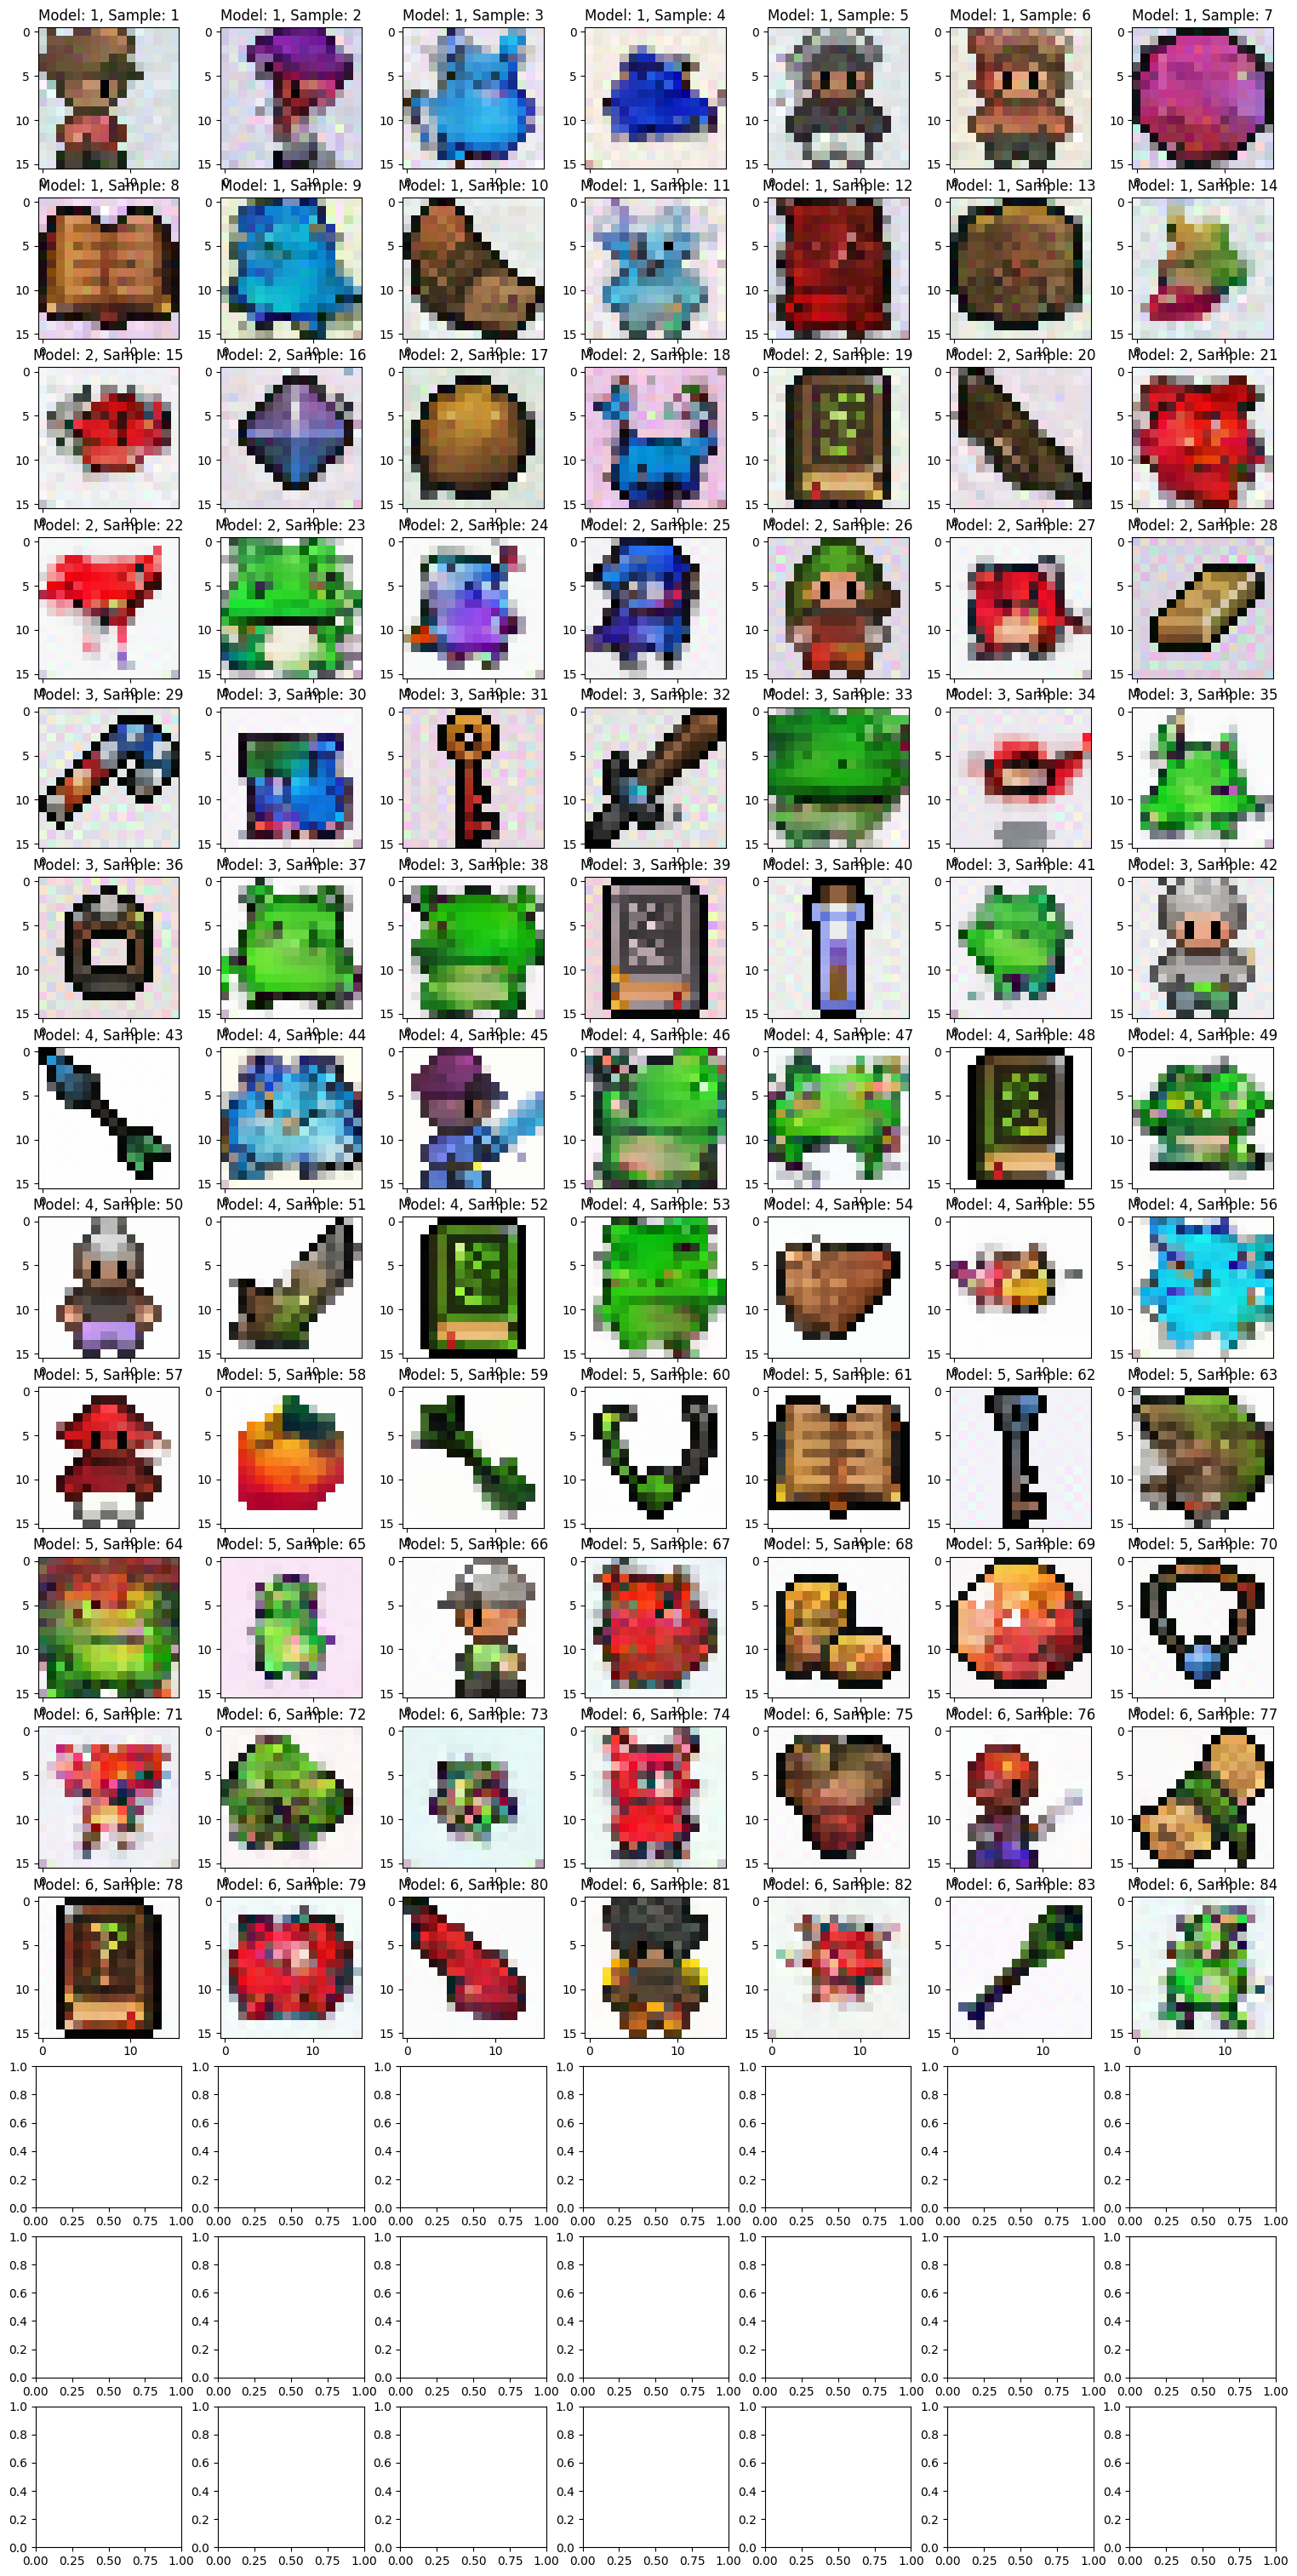

In [152]:
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

fig, axes = plt.subplots(15,7, figsize=(15,30))

flattened_axes = axes.flatten()

for i, sample in enumerate(samples):
    ax = flattened_axes[i]
    ax.set_title(f'Model: {(i//14)+1}, Sample: {i+1}')
    ax.imshow(unorm(sample))

fig.subplots_adjust(hspace=0)
fig.show()
fig.tight_layout(pad=0)